In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [179]:
df_gemma = pd.read_csv('llm_mc1/gemma3_all.csv')
df_phi = pd.read_csv('llm_mc1/phi_all.csv')
df_qwen = pd.read_csv('llm_mc1/qwen2_all.csv')
df_dolphin = pd.read_csv('llm_mc1/tinydolphin_all.csv')
df_llama = pd.read_csv('llm_mc1/tinyllama_all.csv')

In [180]:
len(df_gemma)==len(df_phi)==len(df_qwen)==len(df_dolphin)==len(df_llama)

True

In [181]:
df_gemma_pc = pd.read_csv('llm_mc1/gemma3_pc_all.csv')
df_phi_pc = pd.read_csv('llm_mc1/phi_pc_all.csv')
df_qwen_pc = pd.read_csv('llm_mc1/qwen2_pc_all.csv')
df_dolphin_pc = pd.read_csv('llm_mc1/tinydolphin_pc_all.csv')
df_llama_pc = pd.read_csv('llm_mc1/tinyllama_pc_all.csv')

In [182]:
len(df_gemma_pc)==len(df_phi_pc)==len(df_qwen_pc)==len(df_dolphin_pc)==len(df_llama_pc)

True

# Preprocessing

In [183]:
df = pd.read_json('dataset/mc_task.json')

In [184]:
def mc_dict_to_choices_labels(d: dict):
    """
    Input: {choice_text: 0/1, ...} with exactly one 1
    Output: choices(list[str]), labels(np.array[int]), gold_idx(int)
    """
    choices = list(d.keys())
    labels = np.array([int(v) for v in d.values()], dtype=int)

    # sanity checks
    if labels.sum() != 1:
        raise ValueError(f"Expected exactly one correct answer, got sum={labels.sum()}")

    gold_idx = int(labels.argmax())
    return choices, labels, gold_idx

In [185]:
always_A = True
bad_rows = []

for i, d in enumerate(df["mc1_targets"]):
    choices, labels, gold_idx = mc_dict_to_choices_labels(d)

    if gold_idx != 0:
        always_A = False
        bad_rows.append((i, gold_idx, choices[gold_idx]))

print("Correct answer always A?", always_A)
print("Number of violations:", len(bad_rows))

Correct answer always A? True
Number of violations: 0


In [186]:
import numpy as np

def shuffle_mc_question_from_dict(d, seed=42):
    """
    Input: mc1_targets dict {choice_text: 0/1}
    Output:
      - shuffled_choices (list[str])
      - correct_choice_text (str)
      - gold_idx (int, index in shuffled_choices)
    """
    choices, labels, _ = mc_dict_to_choices_labels(d)

    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(choices))

    shuffled_choices = [choices[i] for i in idx]
    shuffled_labels  = labels[idx]

    gold_idx = int(shuffled_labels.argmax())
    correct_choice_text = shuffled_choices[gold_idx]

    return shuffled_choices, correct_choice_text, gold_idx

In [187]:
df[["shuffled_choices", "correct_choice", "gold_idx"]] = df["mc1_targets"].apply(
    lambda d: pd.Series(shuffle_mc_question_from_dict(d)))

In [188]:
import string

dfs = [df_llama, df_dolphin, df_gemma, df_phi, df_qwen]

for d in dfs:
    d["pred_letter"] = d["pred_idx"].apply(
        lambda x: string.ascii_uppercase[int(x)] if pd.notnull(x) else None
    )

# Distributions

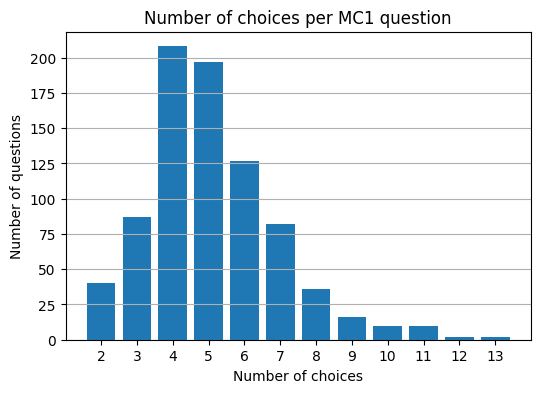

In [189]:
import matplotlib.pyplot as plt

# count number of choices per question
choice_lengths = df["shuffled_choices"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# frequency table
counts = choice_lengths.value_counts().sort_index()

# bar plot
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values)
plt.xlabel("Number of choices")
plt.ylabel("Number of questions")
plt.title("Number of choices per MC1 question")
plt.xticks(counts.index)
plt.grid(axis="y")
plt.show()

In [194]:
def idx_to_letter(idx: int) -> str:
    return chr(ord("A") + idx)

df["gold_letter"] = df["gold_idx"].apply(idx_to_letter)

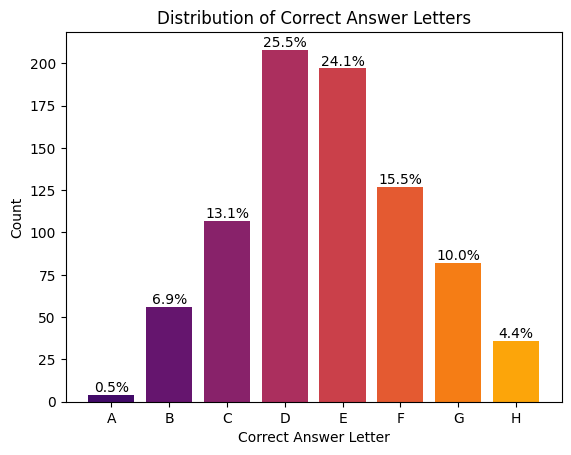

In [195]:
import matplotlib.pyplot as plt
import numpy as np

counts = df["gold_letter"].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

colors = plt.cm.inferno(np.linspace(0.2, 0.8, len(counts)))

plt.figure()
bars = plt.bar(counts.index, counts.values, color=colors)

plt.xlabel("Correct Answer Letter")
plt.ylabel("Count")
plt.title("Distribution of Correct Answer Letters")

# add percentage labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom"
    )

plt.show()

In [192]:
random_guess=0
for i in range(len(df)):
    random_guess+=1/len(df.iloc[i]['shuffled_choices'])
random_guess/=len(df)

print(f"Random guess: {random_guess*100:.2f}%")

Random guess: 22.25%


# Helping functions

In [17]:
import matplotlib.pyplot as plt

def plot_correctness_pie(df, column="correct", title="Correct vs Incorrect Answers"):
    """
    Plots a pie chart of correct vs incorrect answers.

    Args:
        df (pd.DataFrame): DataFrame containing results
        column (str): Column with correctness labels (e.g. True/False or 0/1)
        title (str): Plot title
    """
    counts = df[column].value_counts().sort_index()

    labels = ["Incorrect", "Correct"]
    colors = ["#E74C3C", "#2ECC71"]  # red & green, high contrast

    plt.figure(figsize=(5, 5))
    plt.pie(
        counts.values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
        wedgeprops={"edgecolor": "black", "linewidth": 1}
    )
    plt.title(title)
    plt.axis("equal")
    plt.show()

In [64]:
def plot_time_bar_with_avg(df, time_col="latency_s", bins=10, title="Response Time Distribution"):
    times = df[time_col].values

    # binning
    counts, bin_edges = np.histogram(times, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    avg_time = times.mean()
    median_time = np.median(times)

    total_hours = times.sum() / 3600

    plt.figure(figsize=(6, 4))
    plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9)

    # average line
    plt.axvline(
        avg_time,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Average = {avg_time:.2f} s"
    )

    plt.axvline(
        median_time,
        color="orange",
        linestyle="-.",
        linewidth=2,
        label=f"Median = {median_time:.2f} s"
    )

    plt.plot(
        [],
        [],
        " ",
        label=f"Total time = {total_hours:.2f} h"
    )

    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of questions")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_binary_metrics(df, correct_col='correct'):
    """
    Computes binary classification metrics (accuracy)
    for a column indicating correct predictions (True/False or 1/0).

    Args:
        df (pd.DataFrame): DataFrame containing the results
        correct_col (str): Name of the column indicating correctness

    Returns:
        dict: Dictionary with metrics
    """
    correct = df[correct_col]

    # Compute metrics
    accuracy = accuracy_score(correct, [True]*len(correct))

    # Print nicely
    print(f"Accuracy: {accuracy:.2%}")

    return {'accuracy': accuracy}

In [20]:
def plot_letter_distribution(d, column='pred_letter', title="Distribution of Answer Letters"):
    counts = d[column].value_counts().sort_index()
    total = counts.sum()
    percentages = counts / total * 100

    colors = plt.cm.inferno(np.linspace(0.2, 0.8, len(counts)))

    plt.figure()
    bars = plt.bar(counts.index, counts.values, color=colors)

    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel("Count")
    plt.title(title)

    # Add percentage labels
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{pct:.1f}%",
            ha="center",
            va="bottom"
        )

    plt.show()

# Raspberry Pi

## TinyLlama

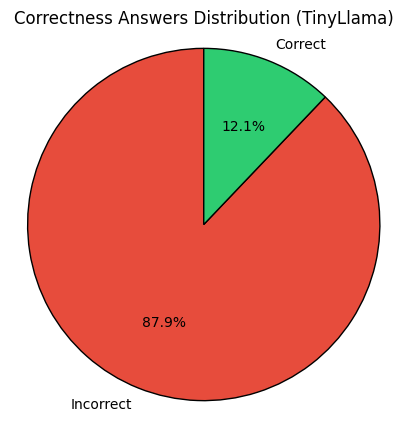

In [21]:
plot_correctness_pie(df_llama, title="Correctness Answers Distribution (TinyLlama)")

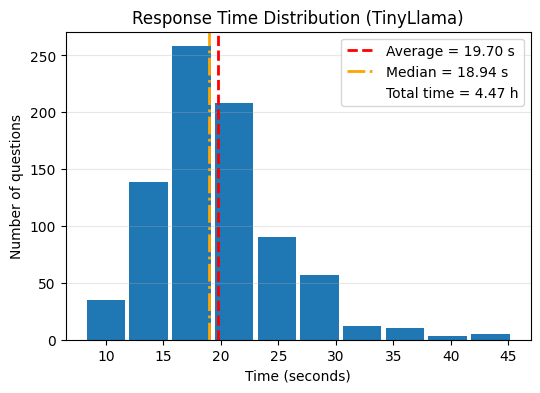

In [22]:
plot_time_bar_with_avg(df_llama, title="Response Time Distribution (TinyLlama)")

In [23]:
metrics_llama = compute_binary_metrics(df_llama)

Accuracy: 12.12%


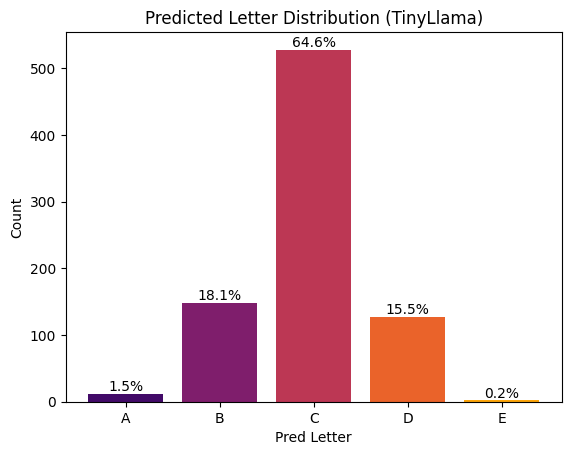

In [24]:
plot_letter_distribution(df_llama, title="Predicted Letter Distribution (TinyLlama)")

## TinyDoplhin

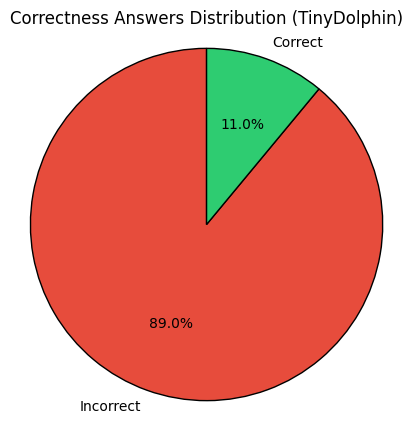

In [25]:
plot_correctness_pie(df_dolphin, title="Correctness Answers Distribution (TinyDolphin)")

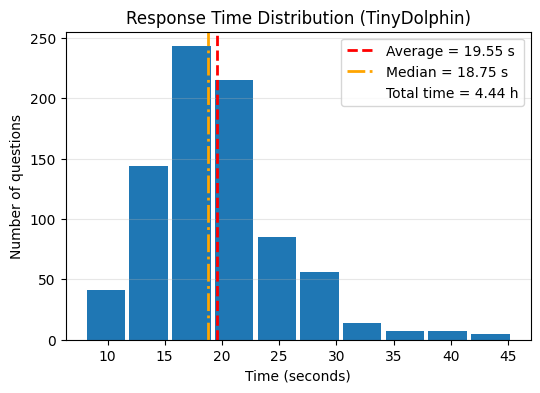

In [26]:
plot_time_bar_with_avg(df_dolphin, title="Response Time Distribution (TinyDolphin)")

In [27]:
metrics_dolphin = compute_binary_metrics(df_dolphin)

Accuracy: 11.02%


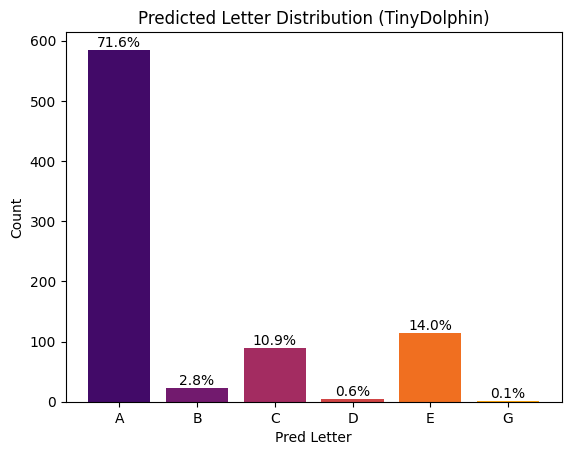

In [28]:
plot_letter_distribution(df_dolphin, title="Predicted Letter Distribution (TinyDolphin)")

## Phi3.5

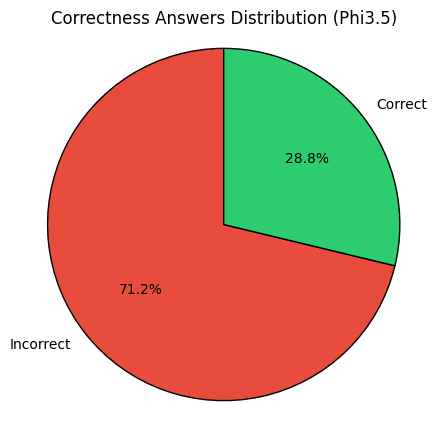

In [29]:
plot_correctness_pie(df_phi, title="Correctness Answers Distribution (Phi3.5)")

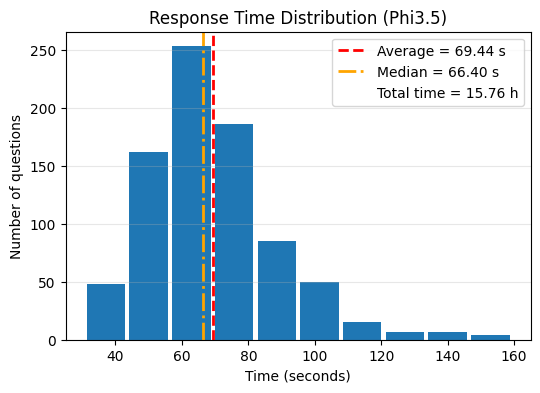

In [30]:
plot_time_bar_with_avg(df_phi, title="Response Time Distribution (Phi3.5)")

In [31]:
metrics_phi = compute_binary_metrics(df_phi)

Accuracy: 28.76%


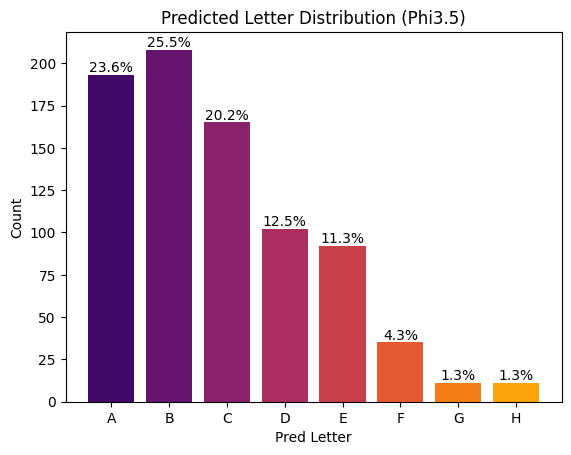

In [32]:
plot_letter_distribution(df_phi, title="Predicted Letter Distribution (Phi3.5)")

## Qwen2.5

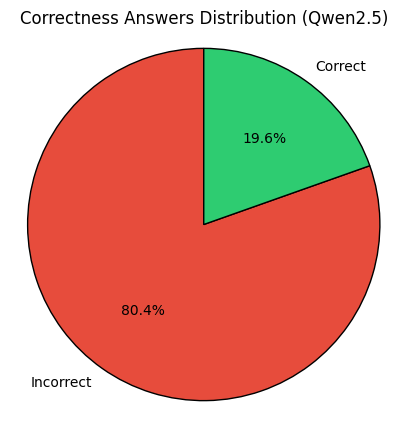

In [33]:
plot_correctness_pie(df_qwen, title="Correctness Answers Distribution (Qwen2.5)")

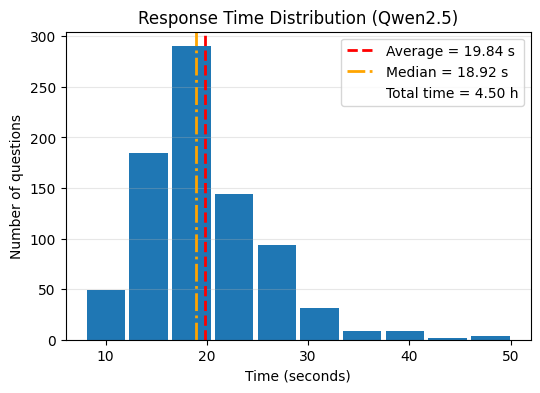

In [34]:
plot_time_bar_with_avg(df_qwen, title="Response Time Distribution (Qwen2.5)")

In [35]:
metrics_qwen = compute_binary_metrics(df_qwen)

Accuracy: 19.58%


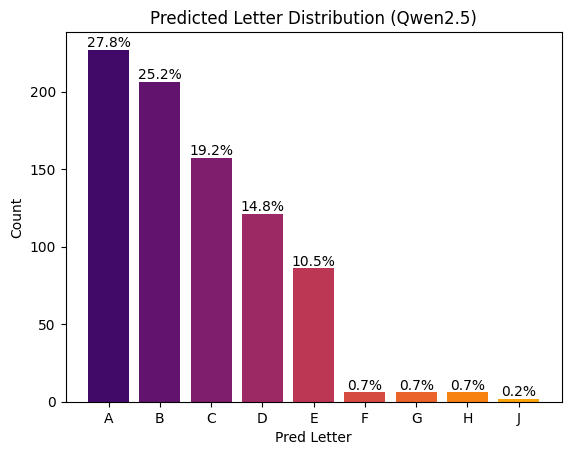

In [36]:
plot_letter_distribution(df_qwen, title="Predicted Letter Distribution (Qwen2.5)")

## Gemma3

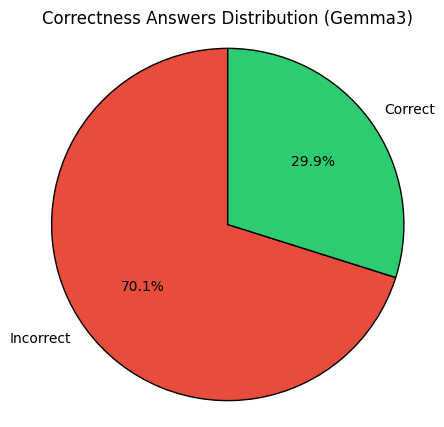

In [37]:
plot_correctness_pie(df_gemma, title="Correctness Answers Distribution (Gemma3)")

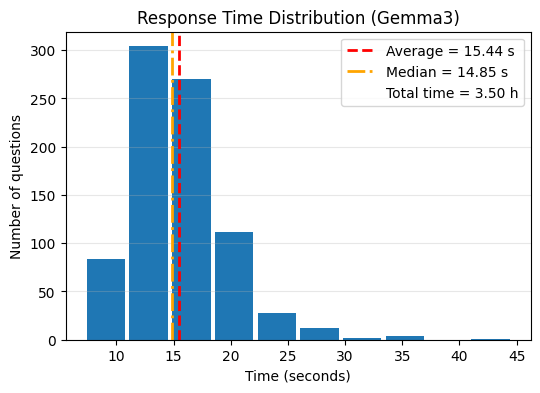

In [38]:
plot_time_bar_with_avg(df_gemma, title="Response Time Distribution (Gemma3)")

In [39]:
metrics_gemma = compute_binary_metrics(df_gemma)

Accuracy: 29.87%


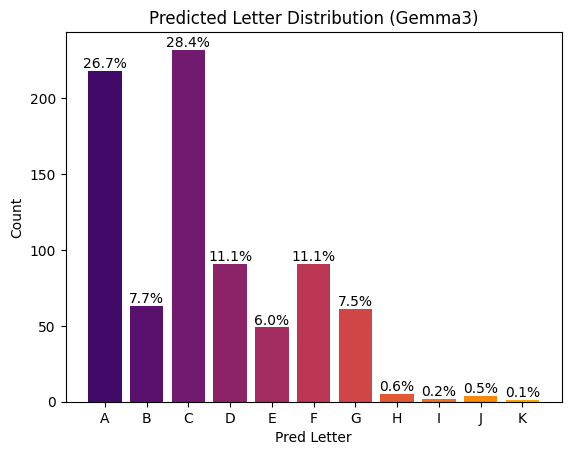

In [40]:
plot_letter_distribution(df_gemma, title="Predicted Letter Distribution (Gemma3)")

## Comparison

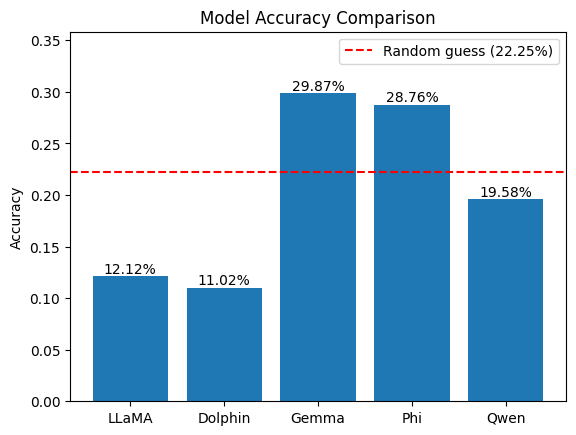

In [41]:
models = {
    "LLaMA": df_llama,
    "Dolphin": df_dolphin,
    "Gemma": df_gemma,
    "Phi": df_phi,
    "Qwen":df_qwen
}

accuracies = {name: df["correct"].mean() for name, df in models.items()}

plt.figure()
plt.bar(accuracies.keys(), accuracies.values())

plt.axhline(random_guess, color = 'red', linestyle="--", label=f"Random guess ({random_guess:.2%})")

plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for i, v in enumerate(accuracies.values()):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")

plt.ylim(0, max(accuracies.values()) * 1.2)
plt.legend()
plt.show()

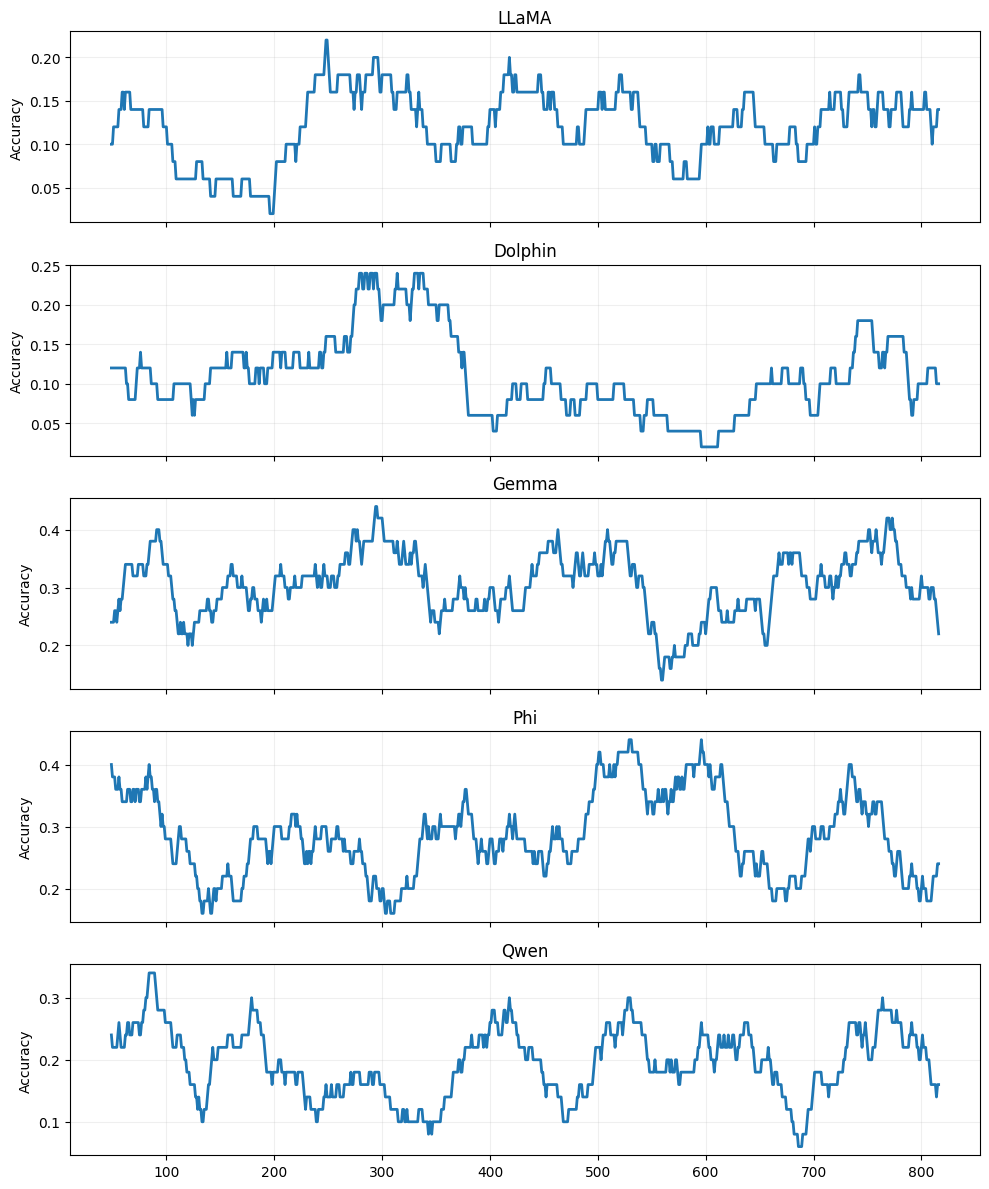

In [42]:
fig, axes = plt.subplots(len(models), 1, figsize=(10,12), sharex=True)

for ax, (name, df) in zip(axes, models.items()):
    roll = df["correct"].rolling(50).mean()
    ax.plot(roll, linewidth=2)
    ax.set_title(name)
    ax.set_ylabel("Accuracy")
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()


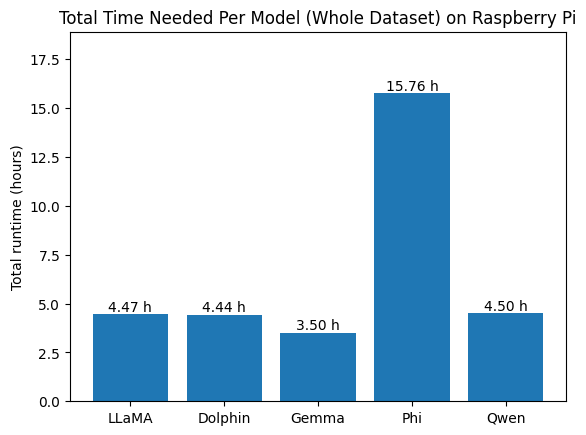

In [147]:
# total time per model (in hours)
total_times = {name: df["latency_s"].sum() / 3600 for name, df in models.items()}

plt.figure()
plt.bar(total_times.keys(), total_times.values())

plt.ylabel("Total runtime (hours)")
plt.title("Total Time Needed Per Model (Whole Dataset) on Raspberry Pi")

for i, v in enumerate(total_times.values()):
    plt.text(i, v, f"{v:.2f} h", ha="center", va="bottom")

plt.ylim(0, max(total_times.values()) * 1.2)
plt.show()

# PC

## TinyLlama

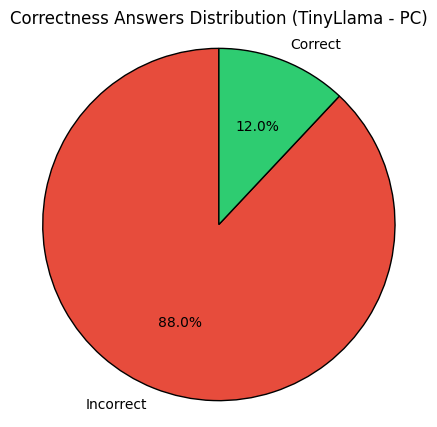

In [86]:
plot_correctness_pie(df_llama_pc, title="Correctness Answers Distribution (TinyLlama - PC)")

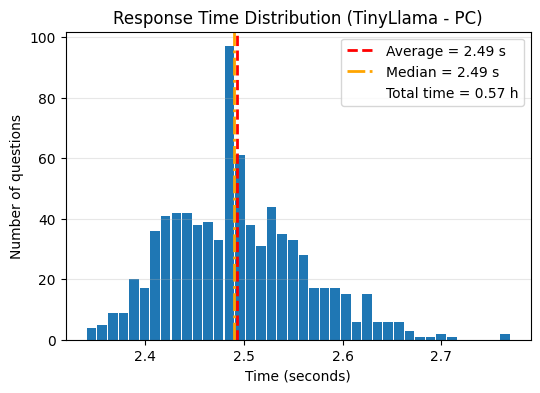

In [87]:
plot_time_bar_with_avg(df_llama_pc, title="Response Time Distribution (TinyLlama - PC)")


In [88]:
metrics_llama_pc = compute_binary_metrics(df_llama_pc)

Accuracy: 12.00%


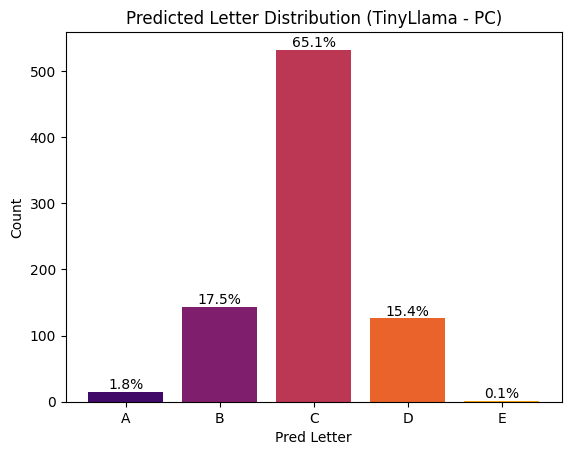

In [89]:
plot_letter_distribution(df_llama_pc, title="Predicted Letter Distribution (TinyLlama - PC)")


## TinyDolphin

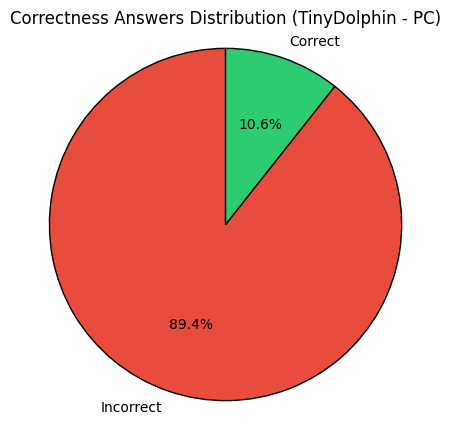

In [90]:
plot_correctness_pie(df_dolphin_pc, title="Correctness Answers Distribution (TinyDolphin - PC)")

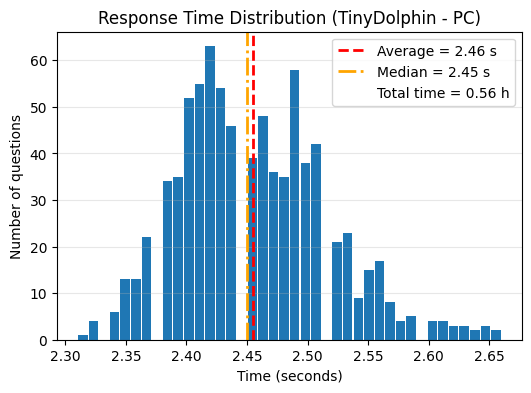

In [91]:
plot_time_bar_with_avg(df_dolphin_pc, title="Response Time Distribution (TinyDolphin - PC)")

In [92]:
metrics_dolphin_pc = compute_binary_metrics(df_dolphin_pc)


Accuracy: 10.65%


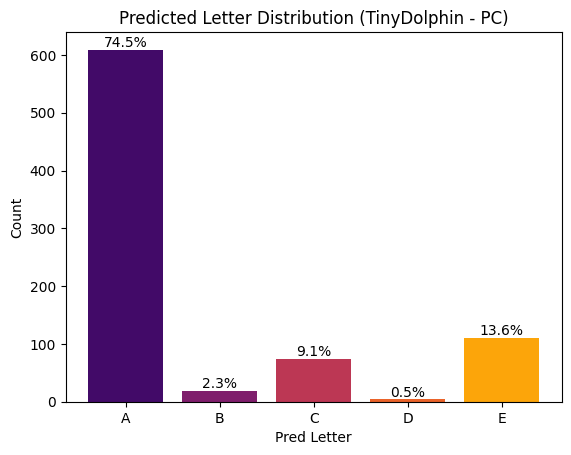

In [93]:
plot_letter_distribution(df_dolphin_pc, title="Predicted Letter Distribution (TinyDolphin - PC)")

## Phi3.5

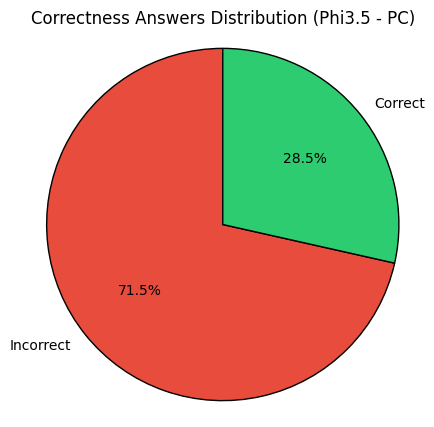

In [94]:
plot_correctness_pie(df_phi_pc, title="Correctness Answers Distribution (Phi3.5 - PC)")

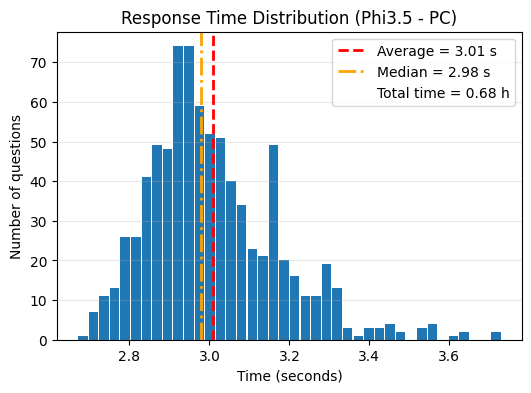

In [95]:
plot_time_bar_with_avg(df_phi_pc, title="Response Time Distribution (Phi3.5 - PC)")

In [96]:
metrics_phi_pc = compute_binary_metrics(df_phi_pc)

Accuracy: 28.52%


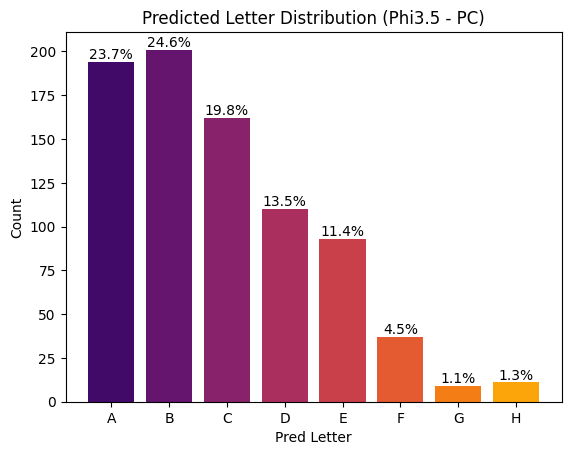

In [97]:
plot_letter_distribution(df_phi_pc, title="Predicted Letter Distribution (Phi3.5 - PC)")

## Qwen2.5

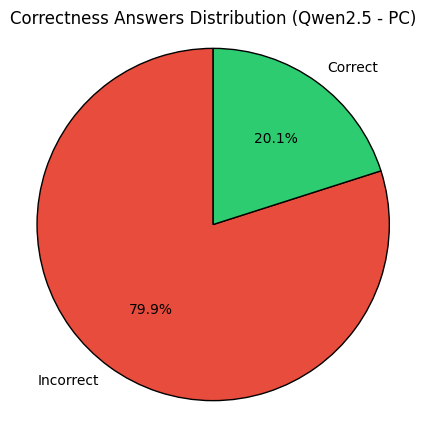

In [98]:
plot_correctness_pie(df_qwen_pc, title="Correctness Answers Distribution (Qwen2.5 - PC)")

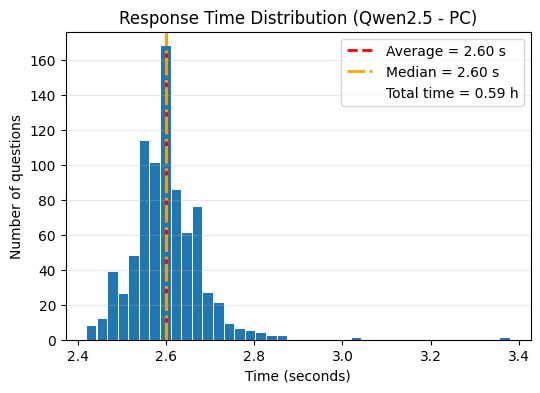

In [99]:
plot_time_bar_with_avg(df_qwen_pc, title="Response Time Distribution (Qwen2.5 - PC)")

In [100]:
metrics_qwen_pc = compute_binary_metrics(df_qwen_pc)

Accuracy: 20.07%


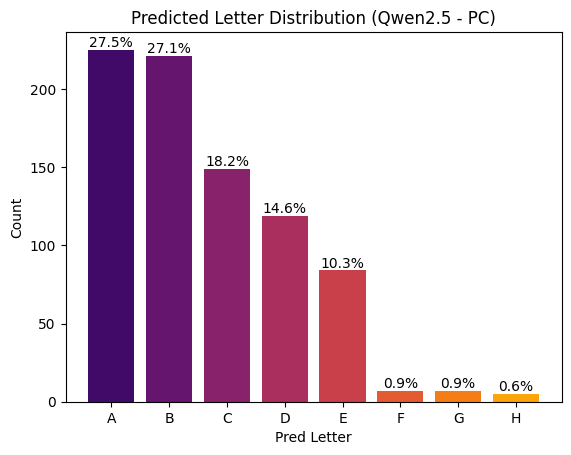

In [101]:
plot_letter_distribution(df_qwen_pc, title="Predicted Letter Distribution (Qwen2.5 - PC)")

## Gemma3

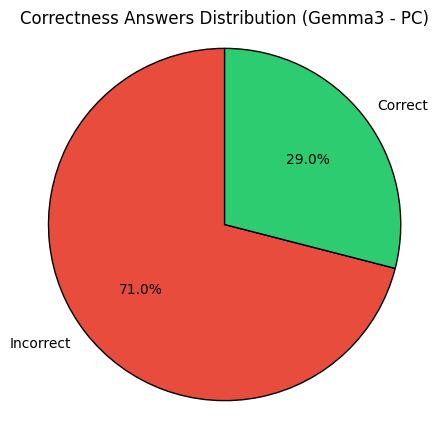

In [102]:
plot_correctness_pie(df_gemma_pc, title="Correctness Answers Distribution (Gemma3 - PC)")

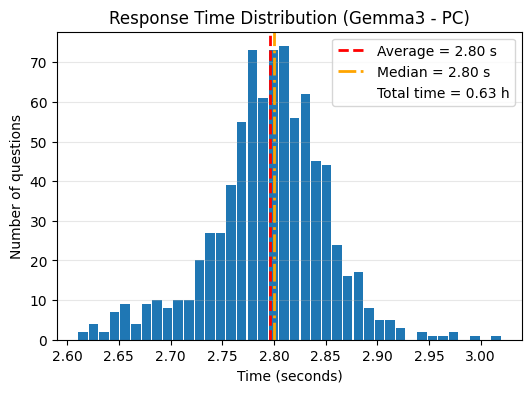

In [103]:
plot_time_bar_with_avg(df_gemma_pc, title="Response Time Distribution (Gemma3 - PC)")

In [104]:
metrics_gemma_pc = compute_binary_metrics(df_gemma_pc)

Accuracy: 29.01%


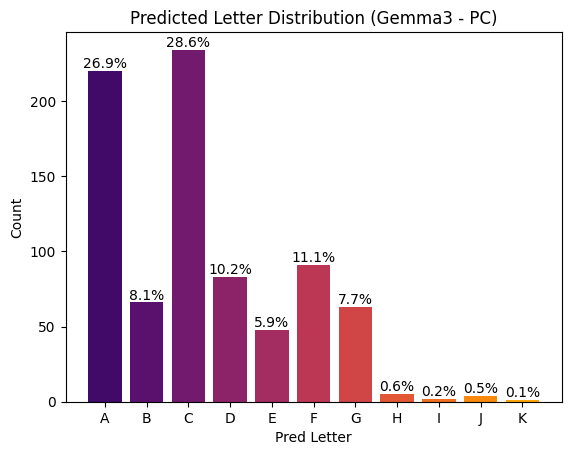

In [105]:
plot_letter_distribution(df_gemma_pc, title="Predicted Letter Distribution (Gemma3 - PC)")

## Comparison

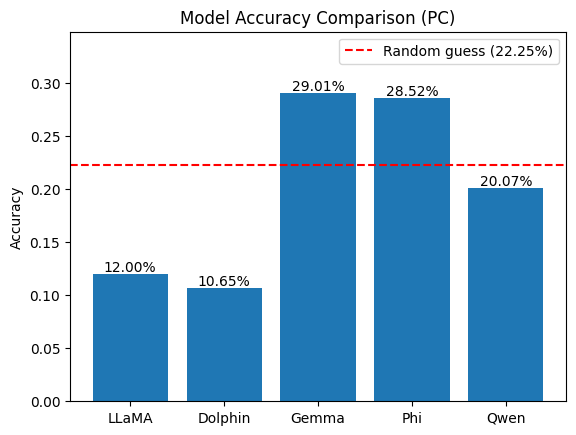

In [161]:
models_comparison = {
    "LLaMA": df_llama_pc,
    "Dolphin": df_dolphin_pc,
    "Gemma": df_gemma_pc,
    "Phi": df_phi_pc,
    "Qwen":df_qwen_pc
}

accuracies = {name: df["correct"].mean() for name, df in models_comparison.items()}

plt.figure()
plt.bar(accuracies.keys(), accuracies.values())

plt.axhline(random_guess, color = 'red', linestyle="--", label=f"Random guess ({random_guess:.2%})")

plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (PC)")

for i, v in enumerate(accuracies.values()):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")

plt.ylim(0, max(accuracies.values()) * 1.2)
plt.legend()
plt.show()

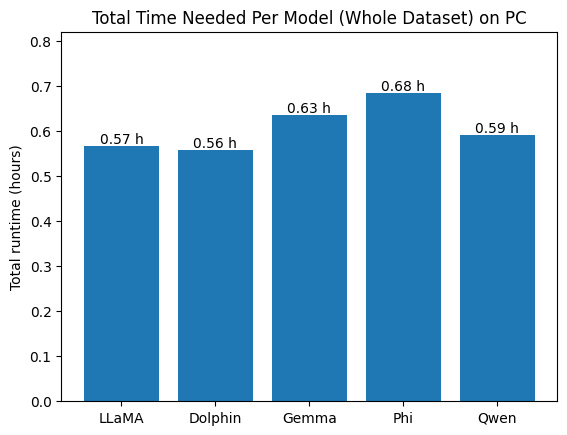

In [146]:
# total time per model (in hours)
total_times_pc = {name: df["latency_s"].sum() / 3600 for name, df in models_pc.items()}

plt.figure()
plt.bar(total_times_pc.keys(), total_times_pc.values())

plt.ylabel("Total runtime (hours)")
plt.title("Total Time Needed Per Model (Whole Dataset) on PC")

for i, v in enumerate(total_times_pc.values()):
    plt.text(i, v, f"{v:.2f} h", ha="center", va="bottom")

plt.ylim(0, max(total_times_pc.values()) * 1.2)
plt.show()

# GPT-OSS

In [134]:
df_oss=pd.read_csv('llm_mc1/gpt-oss.csv')

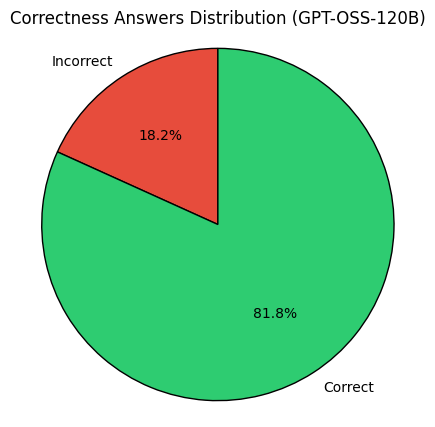

In [136]:
plot_correctness_pie(df_oss, title="Correctness Answers Distribution (GPT-OSS-120B)")

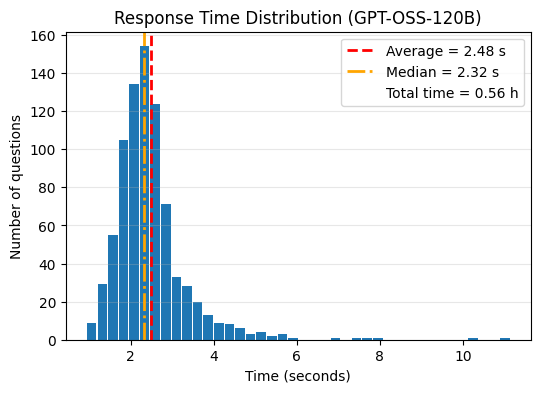

In [137]:
plot_time_bar_with_avg(df_oss, title="Response Time Distribution (GPT-OSS-120B)")

In [138]:
metrics_gemma_oss = compute_binary_metrics(df_oss)

Accuracy: 81.76%


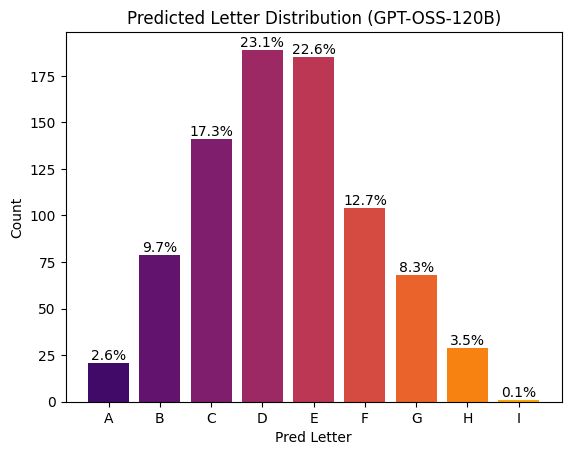

In [139]:
plot_letter_distribution(df_oss, title="Predicted Letter Distribution (GPT-OSS-120B)")

# Final comparison

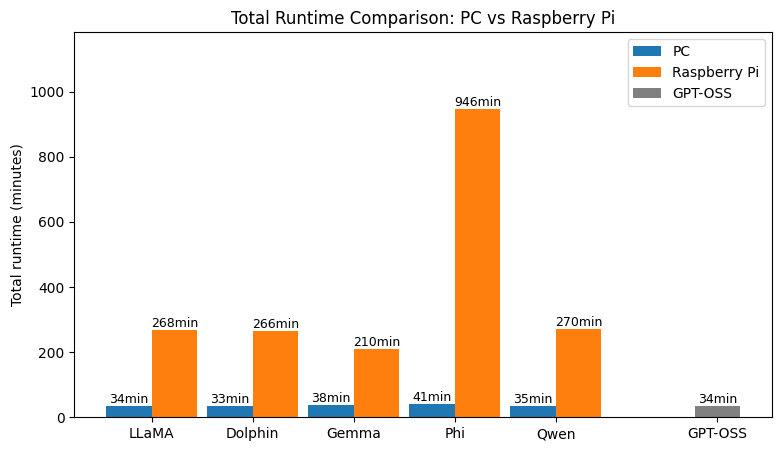

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# models that exist on BOTH devices
model_names = ["LLaMA", "Dolphin", "Gemma", "Phi", "Qwen"]

# total runtime in hours
pc_times = [models_pc[m]["latency_s"].sum() / 60 for m in model_names]
pi_times = [models[m]["latency_s"].sum() / 60 for m in model_names]

# GPT-OSS only one bar (end)
gpt_oss_time = df_oss["latency_s"].sum() / 60

x = np.arange(len(model_names))
width = 0.45

plt.figure(figsize=(9,5))

# PC vs Pi grouped bars
plt.bar(x - width/2, pc_times, width, label="PC")
plt.bar(x + width/2, pi_times, width, label="Raspberry Pi")

# GPT-OSS bar at the end
plt.bar(len(model_names) + 0.6, gpt_oss_time, width, color="gray", label="GPT-OSS")

# labels
plt.xticks(
    list(x) + [len(model_names) + 0.6],
    model_names + ["GPT-OSS"]
)

plt.ylabel("Total runtime (minutes)")
plt.title("Total Runtime Comparison: PC vs Raspberry Pi")
plt.legend()

# value labels
for i, v in enumerate(pc_times):
    plt.text(i - width/2, v, f"{v:.0f}min", ha="center", va="bottom", fontsize=9)

for i, v in enumerate(pi_times):
    plt.text(i + width/2, v, f"{v:.0f}min", ha="center", va="bottom", fontsize=9)

plt.text(len(model_names) + 0.6, gpt_oss_time, f"{gpt_oss_time:.0f}min",
         ha="center", va="bottom", fontsize=9)

plt.ylim(0, max(pc_times + pi_times + [gpt_oss_time]) * 1.25)
plt.show()

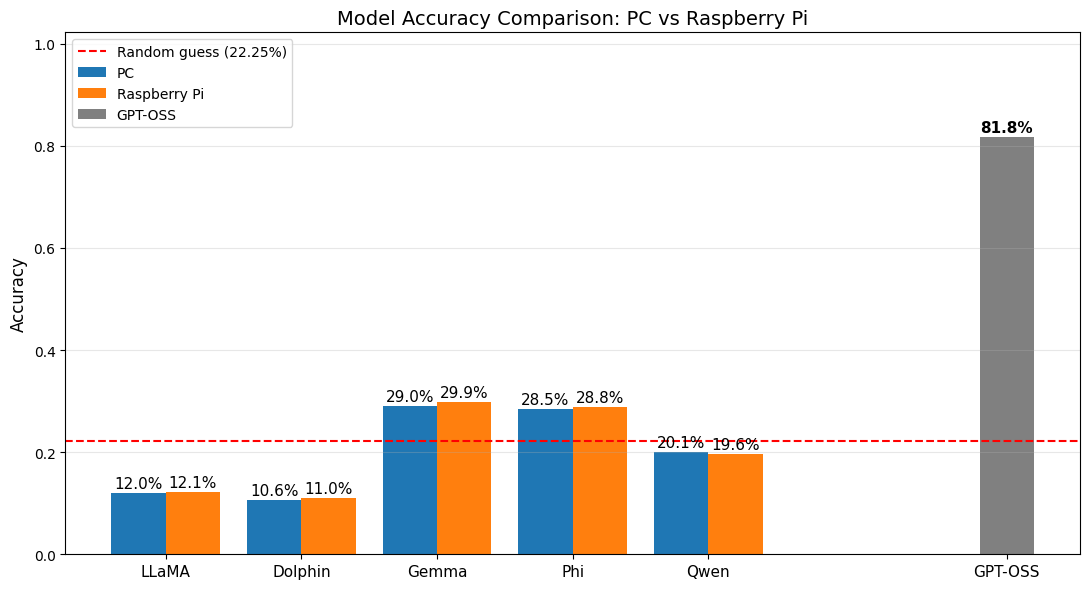

In [173]:
import numpy as np
import matplotlib.pyplot as plt

model_names = ["LLaMA", "Dolphin", "Gemma", "Phi", "Qwen"]

acc_pc = [models_pc[m]["correct"].mean() for m in model_names]
acc_pi = [models[m]["correct"].mean() for m in model_names]
acc_gpt_oss = df_oss["correct"].mean()

x = np.arange(len(model_names))
width = 0.4

plt.figure(figsize=(11,6))

# PC vs Pi
plt.bar(x - width/2, acc_pc, width, label="PC")
plt.bar(x + width/2, acc_pi, width, label="Raspberry Pi")

# GPT-OSS separated
gpt_x = len(model_names) + 1.2
plt.bar(gpt_x, acc_gpt_oss, width, color="gray", label="GPT-OSS")

# random guess
plt.axhline(random_guess, color="red", linestyle="--",
            linewidth=1.5, label=f"Random guess ({random_guess:.2%})")

# labels
plt.xticks(list(x) + [gpt_x], model_names + ["GPT-OSS"], fontsize=11)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison: PC vs Raspberry Pi", fontsize=14)

# BIGGER value labels above bars
for i, v in enumerate(acc_pc):
    plt.text(i - width/2, v + 0.01, f"{v:.1%}", ha="center", fontsize=11)

for i, v in enumerate(acc_pi):
    plt.text(i + width/2, v + 0.01, f"{v:.1%}", ha="center", fontsize=11)

plt.text(gpt_x, acc_gpt_oss + 0.01, f"{acc_gpt_oss:.1%}",
         ha="center", fontsize=11, fontweight="bold")

plt.ylim(0, max(acc_pc + acc_pi + [acc_gpt_oss]) * 1.25)
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


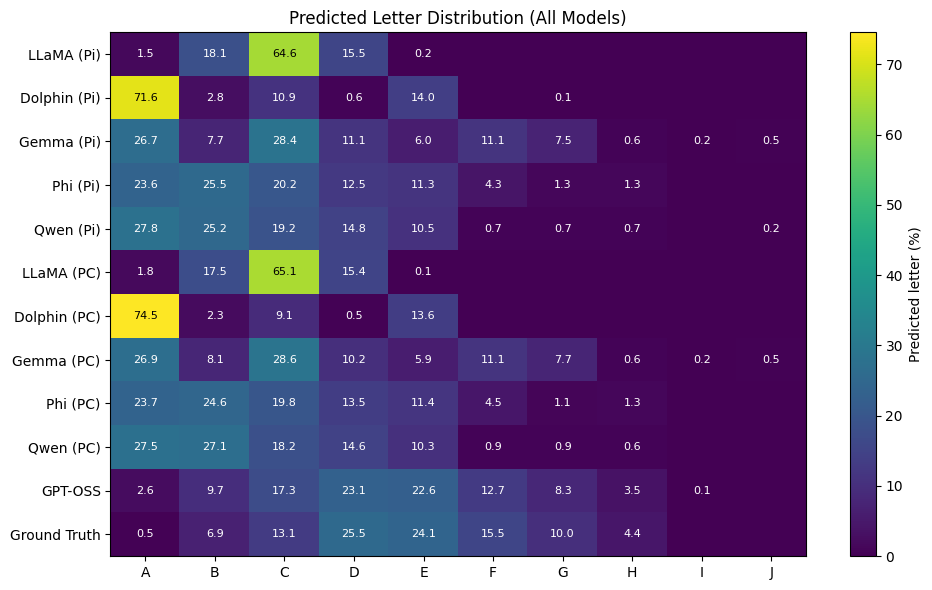

In [196]:
import pandas as pd
import matplotlib.pyplot as plt

letters = list("ABCDEFGHIJ")  # adjust if needed

def letter_pct(df, col="pred_letter"):
    s = df[col].value_counts(normalize=True).reindex(letters, fill_value=0)
    return s * 100

# build rows: (name, df)
rows = []
for name, df in models.items():        # Raspberry Pi
    rows.append((f"{name} (Pi)", letter_pct(df)))
for name, df in models_pc.items():     # PC
    rows.append((f"{name} (PC)", letter_pct(df)))
rows.append(("GPT-OSS", letter_pct(df_oss)))
rows.append(("Ground Truth", letter_pct(df, col="gold_letter")))

mat = pd.DataFrame({k: v for k, v in rows}).T
mat.columns = letters

plt.figure(figsize=(10, 6))
im = plt.imshow(mat.values, aspect="auto")

plt.xticks(range(len(letters)), letters)
plt.yticks(range(len(mat.index)), mat.index)

# colorbar
cbar = plt.colorbar(im)
cbar.set_label("Predicted letter (%)")

# ---- ADD NUMBERS INSIDE CELLS ----
for i in range(mat.shape[0]):          # rows
    for j in range(mat.shape[1]):      # cols
        val = mat.iloc[i, j]
        if val > 0:  # avoid cluttering with zeros
            plt.text(
                j, i,
                f"{val:.1f}",
                ha="center",
                va="center",
                color="black" if val > mat.values.max()*0.5 else "white",
                fontsize=8
            )

plt.title("Predicted Letter Distribution (All Models)")
plt.tight_layout()
plt.show()
